# Import Libraries

In [26]:
import nltk
import pandas as pd
from sklearn import preprocessing,metrics,manifold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# NOTE: Installed kernelspec venv in /home/kenny/.local/share/jupyter/kernels/venv
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import string
# import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /home/kenny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kenny/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kenny/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

In [2]:
# Read csv
imdb_dataset = pd.read_csv('IMDB_Dataset.csv') ## Dataset Without cleaning
imdb_dataset.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Dataset info

In [3]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We haven't found any rows with null values 

## Dataset summary

In [4]:
imdb_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Number of positive and negative reviews

In [5]:
pos_reviews=imdb_dataset[imdb_dataset['sentiment']=='positive'][['review']]
print(f"First 7 samples of positive reviews: \n{pos_reviews.head(7)} \n")
neg_reviews=imdb_dataset[imdb_dataset['sentiment']=='negative'][['review']]
print(f"First 7 samples of negative reviews: \n{neg_reviews.head(7)}")

First 7 samples of positive reviews: 
                                              review
0  One of the other reviewers has mentioned that ...
1  A wonderful little production. <br /><br />The...
2  I thought this was a wonderful way to spend ti...
4  Petter Mattei's "Love in the Time of Money" is...
5  Probably my all-time favorite movie, a story o...
6  I sure would like to see a resurrection of a u...
9  If you like original gut wrenching laughter yo... 

First 7 samples of negative reviews: 
                                               review
3   Basically there's a family where a little boy ...
7   This show was an amazing, fresh & innovative i...
8   Encouraged by the positive comments about this...
10  Phil the Alien is one of those quirky films wh...
11  I saw this movie when I was about 12 when it c...
12  So im not a big fan of Boll's work but then ag...
13  The cast played Shakespeare.<br /><br />Shakes...


In [6]:
# Total count of positive and negative reviews:
print(f"Number of examples in the dataset: {len(imdb_dataset.index)}")
# https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
# len(df.index) is the fastest way to row count of a pandas dataframe
print(imdb_dataset['sentiment'].value_counts())

Number of examples in the dataset: 50000
positive    25000
negative    25000
Name: sentiment, dtype: int64


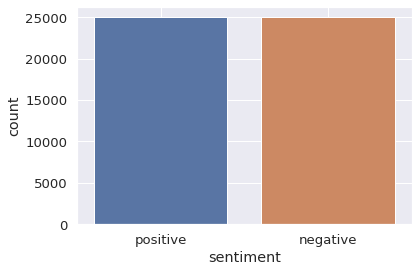

In [7]:
sns.set(style = "dark" , font_scale = 1.2)
sns.countplot(x=imdb_dataset['sentiment'])
plt.grid()

# Most used words for each type of sentiment

In [8]:
def generateWordCloud(data,title="",):
    wc = WordCloud(width = 1600, height = 800, 
                background_color ='black', 
                stopwords = set(STOPWORDS), 
                max_words=2000,
                min_font_size = 10).generate(' '.join(data)) 

    plt.figure(figsize=(8,8))
    plt.imshow(wc)
    plt.title(title)
    plt.axis('off')

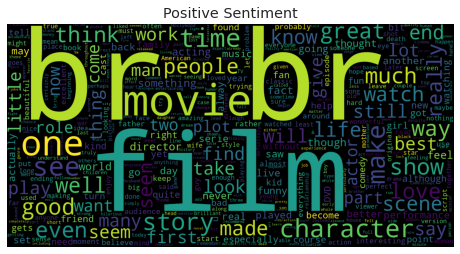

In [9]:
# Wordcloud for positive reviews
generateWordCloud(pos_reviews['review'],'Positive Sentiment')

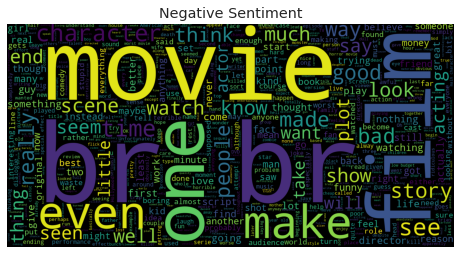

In [10]:
# Wordcloud for negative reviews
generateWordCloud(neg_reviews['review'],'Negative Sentiment')

##  Number of words in each text


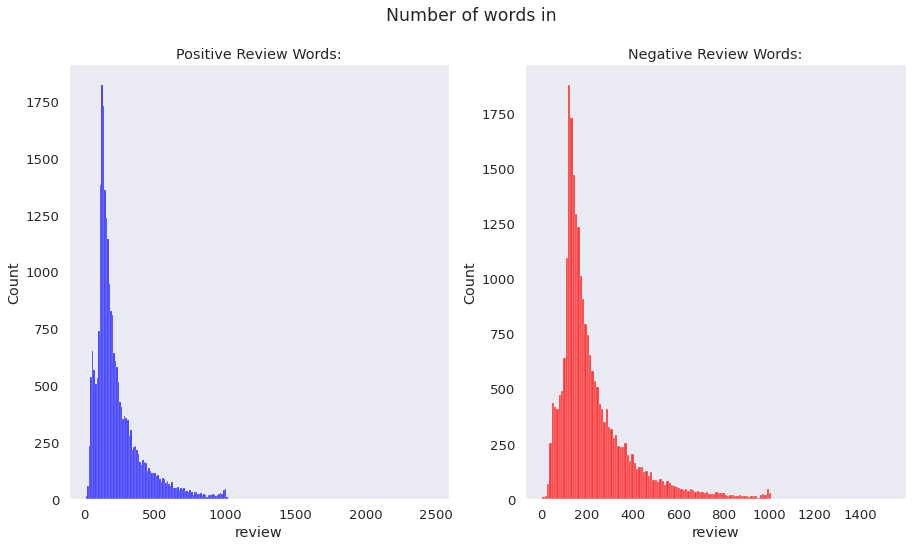

In [11]:
count_pos_words=pos_reviews['review'].str.split().apply(lambda x: len(x))
count_neg_words=neg_reviews['review'].str.split().apply(lambda x: len(x))

# print(f"Positive Review Words: \n{count_pos_words} \n")
# print(f"Negative Review Words: \n{count_neg_words}")
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.histplot(count_pos_words,color='blue')
plt.title("Positive Review Words:")
plt.subplot(1, 2, 2)
sns.histplot(count_neg_words,color='red')
plt.title("Negative Review Words:")
plt.suptitle("Number of words in ")
plt.show()

## Data cleaning

In [12]:

#Use regex to clean the data
def removeUrl(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def removePunct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def removeHtml(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def removeEmojis(text):
    pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return pattern.sub(r'', text)

def removeContraction(text):
    text=re.sub("he's",'he is',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("isn't",'is not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("There's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("That's",'That is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("He's",'He is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("You'll",'You will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("I´m",'I am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('I’m','I am',text)
    text=re.sub('I’d','I did',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('there’s','there is',text)
     
    return text 

def seperateAlphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def contRepChar(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def uniqueChar(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : removeUrl(x))
imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : removePunct(x))
imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : removeHtml(x))
imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : removeEmojis(x))
imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : removeContraction(x))
imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : seperateAlphanumeric(x))
imdb_dataset['review'] = imdb_dataset['review'].apply(lambda x : uniqueChar(contRepChar,x))

In [13]:
imdb_dataset.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production br br The filmin...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [14]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [15]:
# Generate a dataset with clean dataset
# path="dataset_limpio.csv"
# imdb_dataset.to_csv(path,index=False)

## Label Encoding

In [16]:
lencoder=LabelEncoder()
imdb_dataset['sentiment']=lencoder.fit_transform(imdb_dataset['sentiment'])
imdb_dataset.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production br br The filmin...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1


## Text Stemming

In [17]:
def stemmer(text):
    p=nltk.porter.PorterStemmer()
    txt= ' '.join([p.stem(word) for word in text.split()])
    return txt

def lemmatizer(text):
    lem=nltk.stem.WordNetLemmatizer()
    txt= ' '.join([lem.lemmatize(word) for word in text.split()])
    return txt

#After testing, the best way is to use lemmatization
imdb_dataset['review']= imdb_dataset['review'].apply(lemmatizer)    

In [18]:
imdb_dataset.head()

,review,sentiment
0,One of the other reviewer ha mentioned that af...,1
1,A wonderful little production br br The filmin...,1
2,I thought this wa a wonderful way to spend tim...,1
3,Basically there a family where a little boy Ja...,0
4,Petter Matteis Love in the Time of Money is a ...,1


## Lower Case

In [19]:
imdb_dataset['review']=imdb_dataset['review'].apply(lambda x: x.lower())

## Clean whitespace 

In [20]:
imdb_dataset['review']=imdb_dataset['review'].apply(lambda x: x.strip())

## Removing stopwords

In [21]:
stopwords = stopwords.words('english')
for i in stopwords:
    imdb_dataset['review']= imdb_dataset['review'].replace(to_replace=r'\b%s\b'%i, value="",regex=True)
    
imdb_dataset.head(10)

,review,sentiment
0,one reviewer ha mentioned watching 1 oz ...,1
1,wonderful little production br br filming te...,1
2,thought wa wonderful way spend time hot...,1
3,basically family little boy jake think z...,0
4,petter matteis love time money visually s...,1
5,probably alltime favorite movie story selfl...,1
6,sure would like see resurrection dated s...,1
7,show wa amazing fresh innovative idea 70 ...,0
8,encouraged positive comment film wa loo...,0
9,like original gut wrenching laughter like ...,1


## Corpus

In [22]:
def getCorpus(txt):
    return [j.strip() for i in txt for j in i.split()]

corpus = getCorpus(imdb_dataset.review)
corpus[:10]

['one',
 'reviewer',
 'ha',
 'mentioned',
 'watching',
 '1',
 'oz',
 'episode',
 'youll',
 'hooked']

In [35]:
from collections import Counter
counter=Counter(corpus)
most_common = dict(counter.most_common(15))
most_common

{'br': 114938,
 'movie': 98625,
 'wa': 94577,
 'film': 89507,
 'one': 53251,
 'like': 39947,
 'ha': 32962,
 'time': 29156,
 'good': 28680,
 'character': 27396,
 'even': 24580,
 'get': 24415,
 'story': 24208,
 'would': 24024,
 'see': 23592}

In [65]:
def bestNgrams(corpus,n,g=1):
    # corpus, number of examples, ngram
    vector = CountVectorizer(ngram_range=(g,g)).fit(corpus)
    bagOfWords= vector.transform(corpus)
    sumWords= bagOfWords.sum(axis=0)
    words_frequency=[(word, sumWords[0,i]) for word,i in vector.vocabulary_.items()]
    words_frequency =sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:n]

In [66]:
def plotNgrams(corpus,n_words,g,title):
    most_common_ngram=bestNgrams(corpus,n_words,g)
    most_common_ngram=dict(most_common_ngram)
    df= pd.DataFrame(columns=['Common_Words','Count'])
    df["Count"] = list(most_common_ngram.values())
    df["Common_Words"] = list(most_common_ngram.keys())
    sns.barplot(x='Count',y='Common_Words',data=df,label=title,color="b")


### Unigram

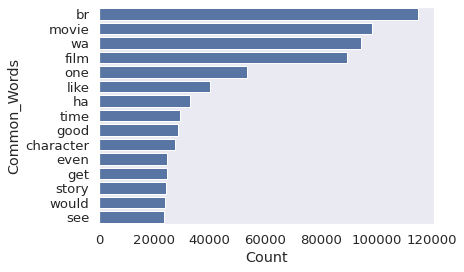

In [67]:
plotNgrams(corpus,15,1,'Commmon Words in Text (UNIGRAM)')

### Bigram

In [69]:
plotNgrams(corpus,15,2,'Commmon Words in Text (BIGRAM)')

ValueError: empty vocabulary; perhaps the documents only contain stop words

### Trigram

In [ ]:
plotNgrams(corpus,15,3,'Commmon Words in Text (TRIGRAM)')

## Training the model

### Spliting the training dataset


In [24]:
y=imdb_dataset['sentiment']
X=imdb_dataset['review']
print(f"Reviews X: \n{X}\n")
print(f"Clasification y: \n{y}")

Reviews X: 
0        one    reviewer ha mentioned   watching  1 oz ...
1         wonderful little production br br  filming te...
2         thought  wa  wonderful way  spend time    hot...
3        basically   family   little boy jake think   z...
4        petter matteis love   time  money   visually s...
                               ...                        
49995     thought  movie    right good job  wasnt  crea...
49996    bad plot bad dialogue bad acting idiotic direc...
49997       catholic taught  parochial elementary schoo...
49998    im going    disagree   previous comment  side ...
49999     one expects  star trek movie   high art   fan...
Name: review, Length: 50000, dtype: object

Clasification y: 
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
